In [373]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [374]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train =  torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test =  torch.utils.data.DataLoader(test, batch_size=10000, shuffle=True)

2 torch.Size([1, 28, 28])


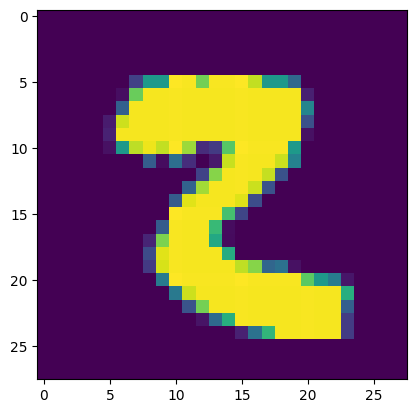

In [375]:
x, y = (next(iter(train)))
plt.imshow(x[0].permute(1, 2, 0))
print(y[0].item(), x[0].shape)

In [376]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(28*28, 25)
        self.tanh1 = nn.Tanh()
        self.l2 = nn.Linear(25, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.tanh1(x)
        x = self.l2(x)
        return x
        
net = Net()

loss_fn = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

trL, vaL = [], []

In [377]:
iterations = 10_000
for i in range(iterations+1):
    bx, by = (next(iter(train)))
    
    cx = net(bx.view(32,-1))
    
    loss = loss_fn(cx, by)
    trL.append(loss.log10().item())

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update
    optimizer.step()
    
    # track stats
    if i % 1000 == 0: # print every once in a while
        with torch.no_grad():
            net.eval()
            
            vx, vy = (next(iter(test)))
            x = net(vx.view(10000,-1))
            vaLoss = loss_fn(x, vy)
            vaL.append(vaLoss.log10().item())
            
            print(f'{i:7d}/{iterations:7d}: tr: {loss.item():.4f}, va: {vaLoss.item():.4f}')
            
            net.train()

      0/  10000: tr: 2.3211, va: 2.2934
   1000/  10000: tr: 0.2667, va: 0.2572
   2000/  10000: tr: 0.6189, va: 0.2412
   3000/  10000: tr: 0.1062, va: 0.2335
   4000/  10000: tr: 0.2662, va: 0.2113
   5000/  10000: tr: 0.1086, va: 0.2398
   6000/  10000: tr: 0.1540, va: 0.1982
   7000/  10000: tr: 0.1023, va: 0.2080
   8000/  10000: tr: 0.2108, va: 0.2090
   9000/  10000: tr: 0.0499, va: 0.1924
  10000/  10000: tr: 0.1239, va: 0.2080


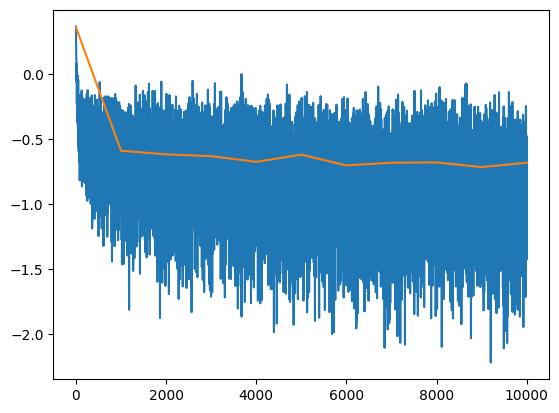

In [378]:
plt.plot(trL)
plt.plot([x for x in range(iterations+1) if x % 1000 == 0], vaL)
plt.show()

Test acc: 0.9376


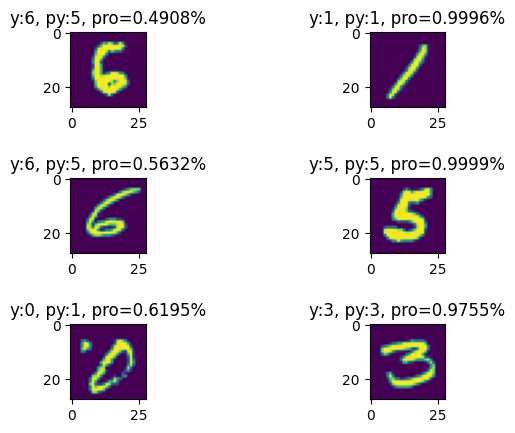

In [379]:
numX, numY = 3, 2
figure, axis = plt.subplots(numX, numY)
figure.tight_layout(pad=3.0)

with torch.no_grad():
    net.eval()

    vx, vy = (next(iter(test)))
    x = net(vx.view(10000,-1))
    yPredP = F.softmax(x, dim=1)
    yPred = torch.argmax(yPredP, dim=1)
    
    print(f"Test acc: {(torch.sum(vy == yPred)/10000).item():.4f}")
    
    missi = (yPred != vy).nonzero(as_tuple=True)[0]
    corri = (yPred == vy).nonzero(as_tuple=True)[0]
    
    for x in range(numX):
        axis[x, 0].imshow(vx[missi[x]].permute(1, 2, 0))
        axis[x, 0].set_title(f"y:{vy[missi[x]].item()}, py:{yPred[missi[x]].item()}, pro={yPredP[missi[x]][yPred[missi[x]].item()]:.4f}%")
        axis[x, 1].imshow(vx[corri[x]].permute(1, 2, 0))
        axis[x, 1].set_title(f"y:{vy[corri[x]].item()}, py:{yPred[corri[x]].item()}, pro={yPredP[corri[x]][yPred[corri[x]].item()]:.4f}%")

plt.show()

In [380]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.drop1 = nn.Dropout2d(p=0.2)
        
        self.conv2 = nn.Conv2d(32, 32, 4)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(16)
        self.drop3 = nn.Dropout2d(p=0.2)
        
        self.l4 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.drop3(x)
        
        x = torch.flatten(x,1)
        
        x = self.l4(x)
        return x
        
net2 = Net2()

loss_fn2 = F.cross_entropy
optimizer2 = torch.optim.Adam(net2.parameters(), lr=0.01)

trL2, vaL2 = [], []

In [381]:
iterations = 10_000
for i in range(iterations+1):
    bx, by = (next(iter(train)))
    
    cx = net2(bx)
    
    loss = loss_fn2(cx, by)
    trL2.append(loss.log10().item())

    # backward pass
    optimizer2.zero_grad()
    loss.backward()

    # update
    optimizer2.step()
    
    # track stats
    if i % 1000 == 0: # print every once in a while
        with torch.no_grad():
            net2.eval()
            
            vx, vy = (next(iter(test)))
            x = net2(vx)
            vaLoss = loss_fn2(x, vy)
            vaL2.append(vaLoss.log10().item())
            
            print(f'{i:7d}/{iterations:7d}: tr: {loss.item():.4f}, va: {vaLoss.item():.4f}')
            
            net2.train()

      0/  10000: tr: 2.5034, va: 2.2740
   1000/  10000: tr: 0.0113, va: 0.0612
   2000/  10000: tr: 0.0734, va: 0.0523
   3000/  10000: tr: 0.0157, va: 0.0444
   4000/  10000: tr: 0.0755, va: 0.0419
   5000/  10000: tr: 0.0157, va: 0.0411
   6000/  10000: tr: 0.0242, va: 0.0372
   7000/  10000: tr: 0.0215, va: 0.0460
   8000/  10000: tr: 0.1655, va: 0.0352
   9000/  10000: tr: 0.0316, va: 0.0274
  10000/  10000: tr: 0.1906, va: 0.0287


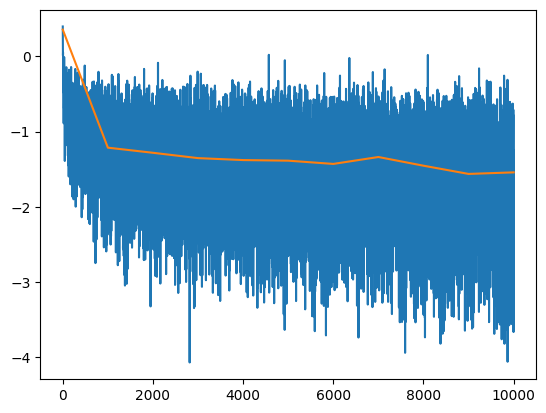

In [382]:
plt.plot(trL2)
plt.plot([x for x in range(iterations+1) if x % 1000 == 0], vaL2)
plt.show()

Test acc: 99.10%


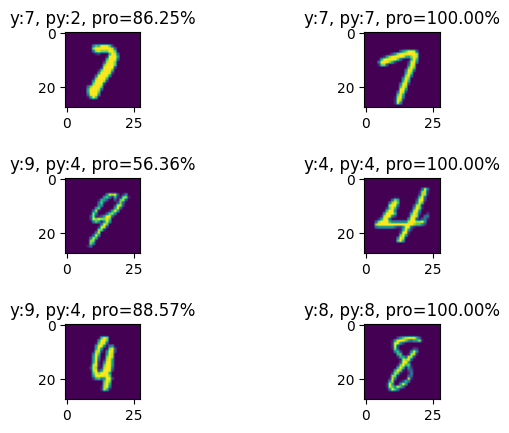

In [383]:
numX, numY = 3, 2
figure, axis = plt.subplots(numX, numY)
figure.tight_layout(pad=3.0)

with torch.no_grad():
    net2.eval()

    vx, vy = (next(iter(test)))
    x = net2(vx)
    yPredP = F.softmax(x, dim=1)
    yPred = torch.argmax(yPredP, dim=1)
    
    print(f"Test acc: {(torch.sum(vy == yPred)/10000).item()*100:.2f}%")
    
    missi = (yPred != vy).nonzero(as_tuple=True)[0]
    corri = (yPred == vy).nonzero(as_tuple=True)[0]
    
    for x in range(numX):
        axis[x, 0].imshow(vx[missi[x]].permute(1, 2, 0))
        axis[x, 0].set_title(f"y:{vy[missi[x]].item()}, py:{yPred[missi[x]].item()}, pro={yPredP[missi[x]][yPred[missi[x]].item()]*100:.2f}%")
        axis[x, 1].imshow(vx[corri[x]].permute(1, 2, 0))
        axis[x, 1].set_title(f"y:{vy[corri[x]].item()}, py:{yPred[corri[x]].item()}, pro={yPredP[corri[x]][yPred[corri[x]].item()]*100:.2f}%")

plt.show()

Best found: 99.10%